<a href="https://colab.research.google.com/github/catherinesyeh/protein-viz/blob/main/protein_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating Protein-Protein Interactions in Python

This notebook will explore different ways to visualize the protein interaction networks of *VIM* and *RASL11A* using Python libraries and tools. Many of the techniques used were adapted from Ford Comb's [Visualizing protein interaction networks in Python](https://towardsdatascience.com/visualizing-protein-networks-in-python-58a9b51be9d5) and [Chord diagrams of protein interaction networks in Python](https://towardsdatascience.com/chord-diagrams-of-protein-interaction-networks-in-python-9589affc8b91) tutorials.

You can follow along by pressing the play button at the top-left corner of each code cell. This will run the code and generate the corresponding output. *Note: cells must be run sequentially or else unexpected errors may occur.*

### Notebook Outline:
*   [Part A: Protein Interaction Map](#part_a)
*   [Part B: Chord Diagrams of Protein Interactions](#part_b)
*   [Part C: Your Turn!](#part_c)



<a id='part_a'></a>
## Part A: Protein Interaction Map
Let's look at *RASL11A* first. We'll be building a protein interaction map, similar to the ones generated by the [Human Reference Interactome](http://www.interactome-atlas.org/) (HuRI). 

First, let's import the necessary libraries and packages.

In [ ]:
# required libraries and packages
!pip install networkx
!pip install pandas
!pip install matplotlib

import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Next, we'll load data from the [STRING](https://string-db.org/cgi/input?sessionId=bRJVMkM0z6Jg&input_page_show_search=on/) database using an HTTP request.

In [ ]:
# getting protein interation data
def return_data(protein_list):
  proteins = '%0d'.join(protein_list) # protein identifiers will be separated by %0d's
  # tsv = tab separated values, &species=9606 gives us human data
  url = 'https://string-db.org/api/tsv/network?identifiers=' + proteins + '&species=9606'
  r = requests.get(url)
  return r

r = return_data(['RASL11A']) # get data for RASL11A

Now, we'll convert the data into a pandas dataframe so we can create our network.

In [ ]:
def gen_dataframe(r):
  lines = r.text.split('\n') # pull data from r and split by new lines
  data = [l.split('\t') for l in lines] # split each line into its components (separated by tabs)
  # convert to dataframe; use first row as column names, drop last column (empty)
  df = pd.DataFrame(data[1:-1], columns = data[0])
  return df

df = gen_dataframe(r)
# print columns in dataframe
print("Columns in dataframe:")
for c in df.columns:
  print(" -", c)

In [ ]:
def get_interactions(df):
  # rename columns for ease of use
  df = df.rename(columns={"preferredName_A": "name_A", "preferredName_B": "name_B"})
  df['score'] = df['score'].astype(float) # convert scores to floats instead of strings
  # make smaller dataframe with name_A, name_B, and (interaction) score
  interactions = df[['name_A', 'name_B', 'score']]
  return interactions

interactions = get_interactions(df)
print(interactions.head()) # let's look at a few entries

Great! Now we can start making our graph with NetworkX.

In [ ]:
def build_G(interactions, protein):
  # initialize graph
  G = nx.Graph(name=protein + ' Protein Interaction Graph')
  interactions = np.array(interactions) # convert to numpy array

  # add each interaction to the graph
  for i in range(len(interactions)):
    interaction = interactions[i]
    a = interaction[0] # protein a node
    b = interaction[1] # protein b node
    w = float(interaction[2]) # use interaction score to create weighted edge
    
    G.add_weighted_edges_from([(a,b,w)]) # add weighted edge to graph

  return G

G = build_G(interactions, "RASL11A")

Let's see what that looks like so far.

In [ ]:
# simple visualization of G
pos = nx.spring_layout(G) # position nodes using one of NetworkX's positioning algorithms
plt.figure(figsize=(10, 10))
nx.draw_networkx(G)
plt.axis('off')
plt.show()

That's pretty cool, but we can make things even more exciting. Let's add some colors and rescale the nodes/edges to encode additional information about our network.

In [ ]:
# helper function to rescale values
def rescale(l, new_min, new_max):
  arr = list(l)
  old_min = min(arr)
  old_range = max(arr) - old_min
  new_range = new_max - new_min
  # change range of values from [old_min, old_max] --> [new_min, new_max]
  new_vals = [((x - old_min) / old_range) * new_range + new_min for x in arr]
  return new_vals

def customize_graph(G):
  # load matplotlib colormaps
  colors = cm.get_cmap('RdPu')

  # vary node size & color by degree (i.e., # edges coming out of each node)
  s = rescale([G.degree(v) for v in G], 1500, 3000) # rescale node size
  c = [colors((i - 1000)/1500) for i in s] # color nodes accordingly

  # edge width & color shows strength of interaction
  ew = rescale([float(G[u][v]['weight']) for u,v in G.edges], 2, 8) # rescale edge weights

  return [s, c, ew]

# save returned values
res = customize_graph(G)
s = res[0] # node sizes
c = res[1] # node colors
ew = res[2] # edge widths (which will also be used to color edges accordingly)

Okay, let's see what we have now!

In [ ]:
def make_map(G, s, c, ew, protein):
  # generate network map again
  pos = nx.spring_layout(G)
  plt.figure(figsize=(12, 10))
  # set more options using the rescaling/other variables we created above
  nx.draw_networkx(G, pos=pos, with_labels=True, node_color=c, node_size=s, 
                  edge_color=ew, width=ew, edge_cmap=cm.OrRd, edge_vmin=0.3,
                  font_color='white', font_weight='bold', font_size='8')
  plt.axis('off')
  plt.title(protein + " Protein Interaction Map", fontsize=16)
  plt.show()

make_map(G, s, c, ew, "RASL11A")

Amazing! This graph gives us more information. The more purple/less pink and larger a node is, the higher the degree (aka. more interactions). Similarly, the more red/less orange and thicker an edge is, the higher the interaction score.

For reference, [here](https://string-db.org/cgi/network?taskId=bNhuUMyfVMu5&sessionId=b5GInwZ5N4tE) is the original search result for *RASL11A* on STRING. On HuRI, there are no results if you search *RASL11A*.

We can also learn a little more about our interaction map using some simple statistics and pre-existing methods.

In [ ]:
def print_stats(G, interactions):
  print("GRAPH INFO")
  print(nx.info(G)) # see some info about our graph

  print("\nINTERACTION SCORE INFO")
  scores = interactions['score'] # extract score column
  mean = scores.mean() # compute mean score
  median = scores.median() # compute median score
  min = scores.min() # compute min score
  max = scores.max() # compute max score
  sd = scores.std() # compute standard deviation of scores
  range = max - min # compute range of scores

  # build output
  output = "Median score: {:.2f}\tMean score: {:.2f}\nMin score: {:.2f}\t\t"
  output += "Max score: {:.2f}\nRange: {:.2f}\t\tSD: {:.2f}"
  print(output.format(median, mean, min, max, range, sd))

print_stats(G, interactions)

So it looks like on average, each of the **11** proteins in the *RASL11A* network has **3.63** interactions, and in total there are **20** interactions between all of the proteins in the network. We also see that the median interaction score is **0.56** (and the mean interaction score is **0.59**). The min interaction score is **0.43** and the max is **0.90**.

Alright, now since we've already built all the necessary functions, we can easily create the same graph for *VIM*, our other gene of interest.

In [ ]:
# let's create a 'master' function that essentially runs all the code necessary
# to generate our interaction network for a specific protein
def build_interaction_map(protein):
  r = return_data([protein]) # get data for protein
  if not r: # error
    print("Protein not found. Please try again.")
    return
  df = gen_dataframe(r) # convert data into dataframe
  interactions = get_interactions(df) # build interactions dataframe
  G = build_G(interactions, protein) # build graph

  # we can skip to the fancier visualization this time :)
  res = customize_graph(G)
  s = res[0] # node sizes
  c = res[1] # node colors
  ew = res[2] # edge widths (which will also be used to color edges accordingly)
  make_map(G, s, c, ew, protein) # generate our final visualization!

  print_stats(G, interactions) # print stats

# building protein interaction map for VIM
build_interaction_map("VIM")

Wow, it seems there's a lot more protein interactions with higher interaction scores in *VIM*'s interaction network as illustrated by the thick, dark red edges. We also see that each node tends to have a higher degree (i.e., more interactions) on average than in the *RASL11A* network above as illustrated by the majority of nodes being on the purpler and larger side. 

These observations are also supported by the statistics we printed out. It looks like on average, each of the **11** proteins in the *VIM* network has **5.27** interactions (v.s. 3.63 in the *RASL11A* network), and in total there are **29** interactions between all of the proteins in the network (which is also more than the 20 in the *RASL11A* network). We also see that the median interaction score is **0.94** (and the mean interaction score is **0.84**), both of which are a lot higher than the *RASL11A* network. But the min interaction score of **0.40** and the max of **1.00** are pretty similar to the *RASL11A* network.

For reference, [here](https://string-db.org/cgi/network?taskId=bRt9TUCqervg&sessionId=b5GInwZ5N4tE) is the original search result for *VIM* on STRING. On HuRI, there are 58 interactions returned (shown below), which is a lot more than documented on STRING.

These diagrams also seem to predict no overlapping interactions between *RASL11A* and *VIM*, but perhaps our independent project will help provide evidence of an interaction (or lack thereof).

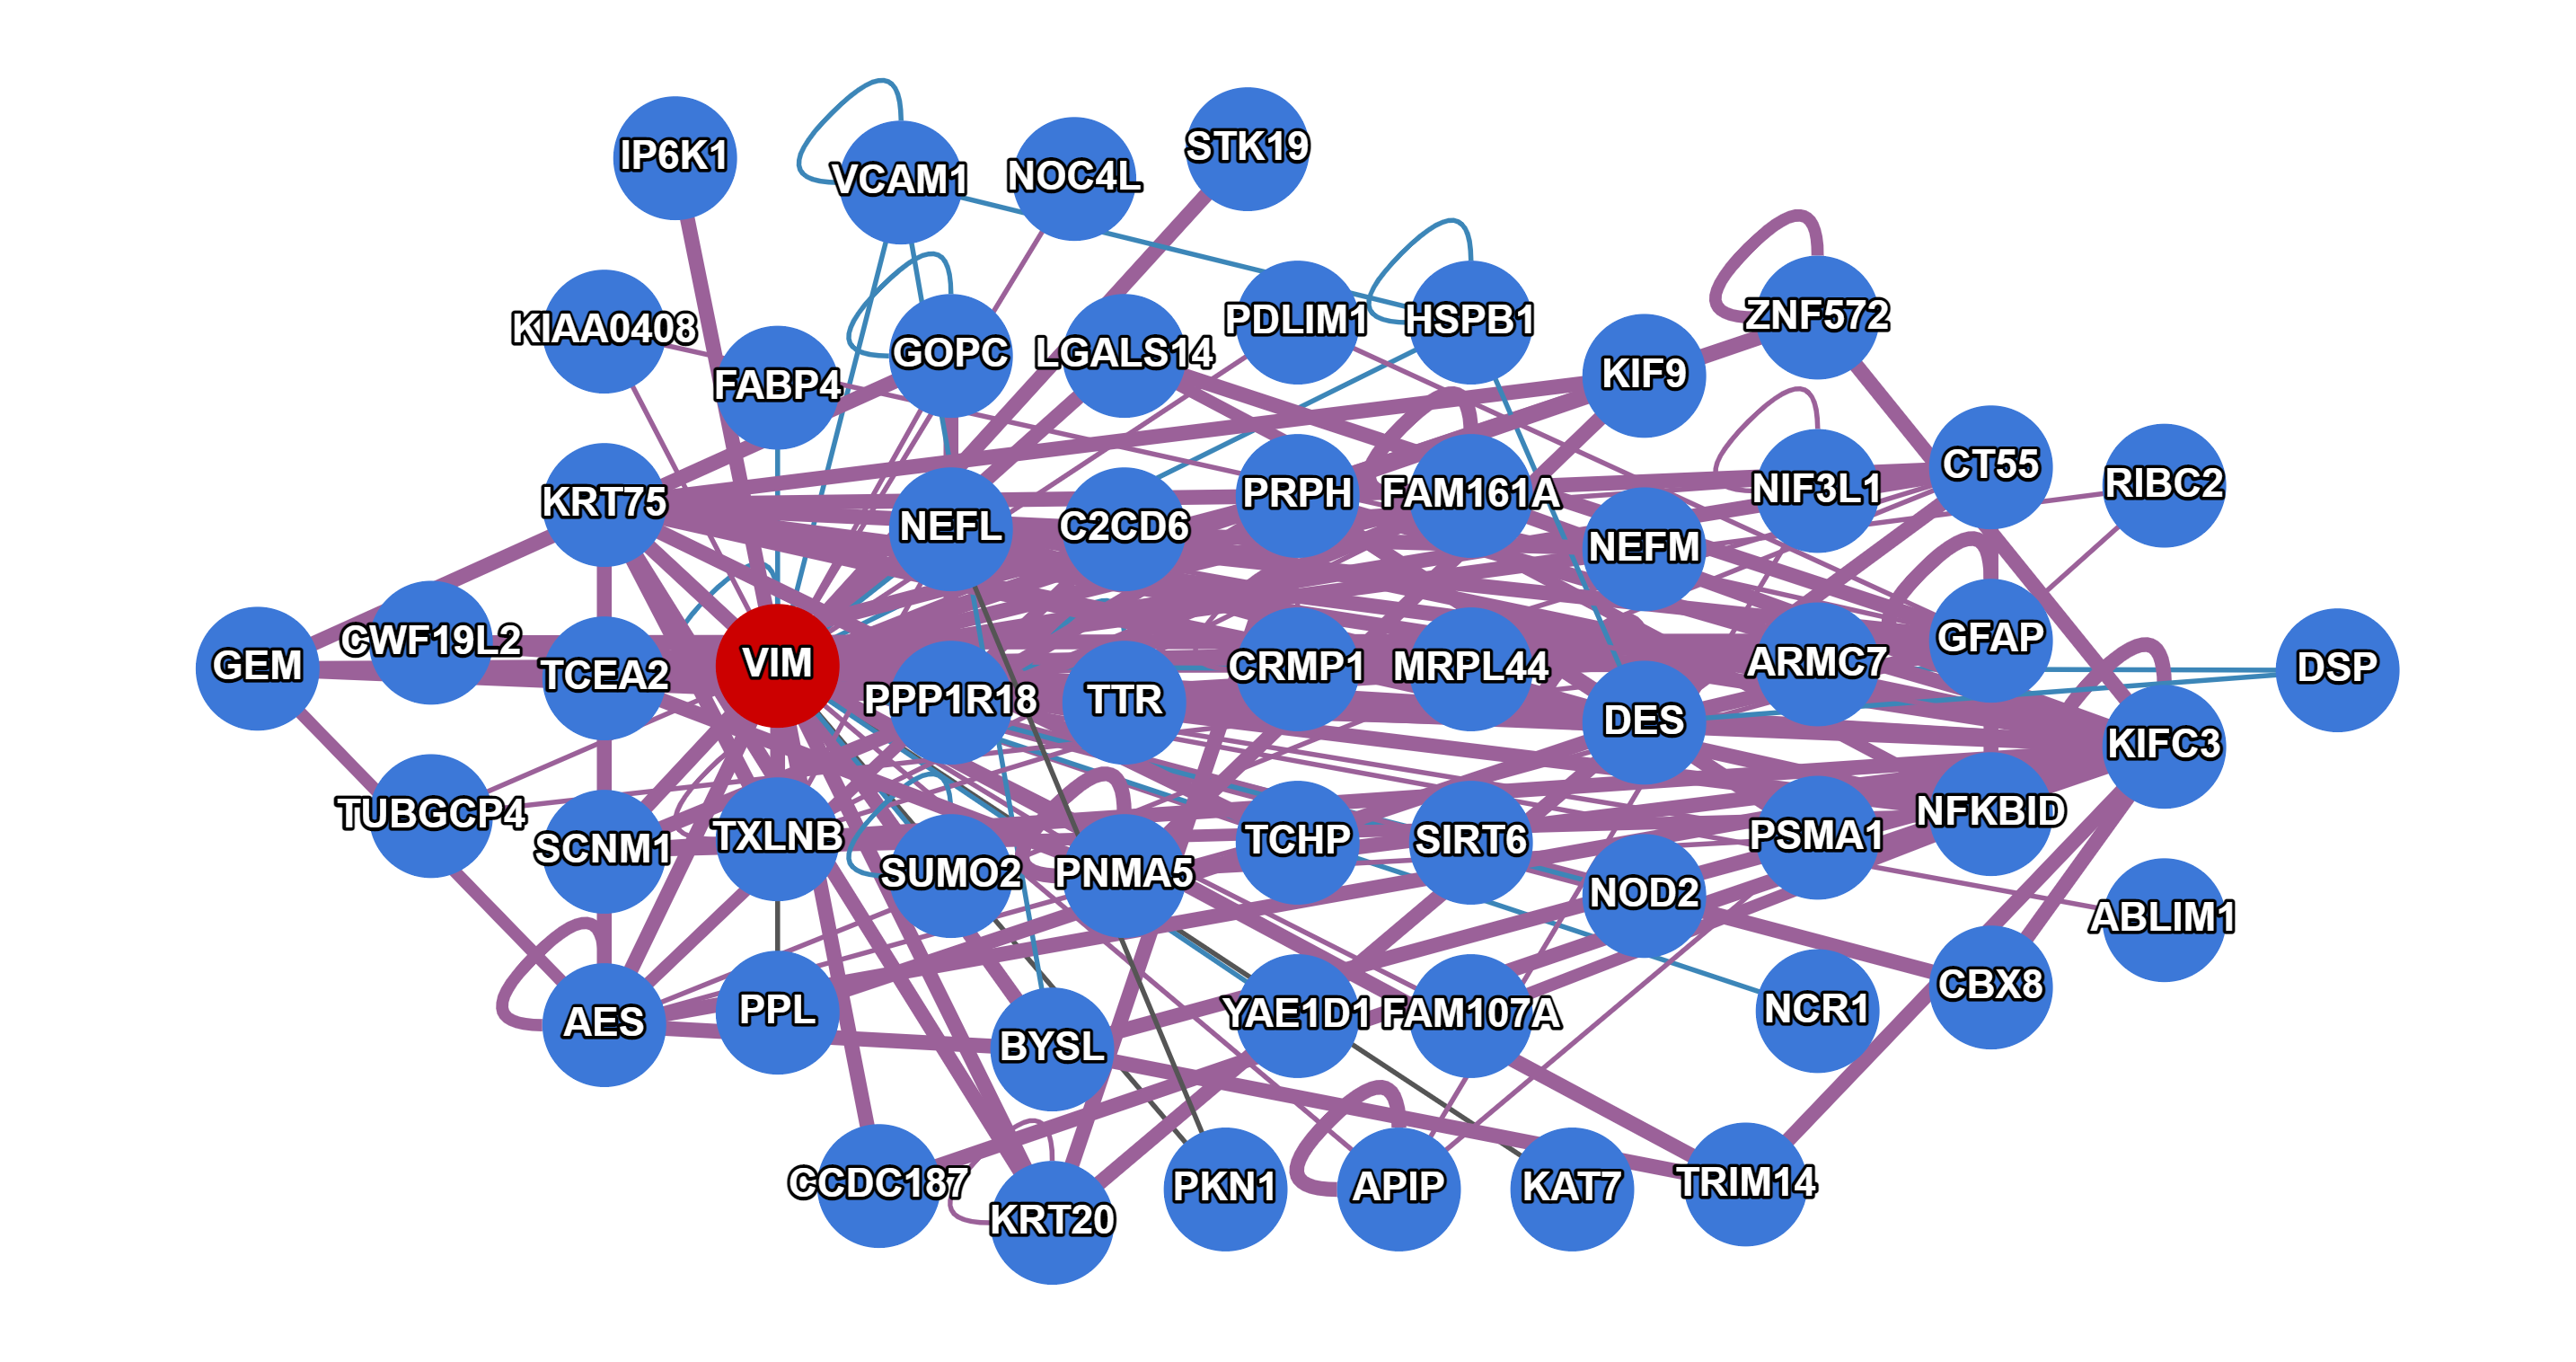

<a id='part_b'></a>
## Part B: Chord Diagrams of Protein Interactions

We can also visualization our protein interaction networks using a chord diagram. We just need to import a few more libraries and packages before diving in.

In [ ]:
# install one more package
!pip install nxviz
from nxviz.plots import CircosPlot

The first few steps are actually pretty similar to what we did when building the protein interaction maps above. We'll first get the data from STRING and then convert it into a dataframe storing only the relevant interaction data. And again, we'll start with *RASL11A*.

*Note: We technically do not have to redo these steps since we've already imported and saved the data about RASL11A above, but for completeness, **all** necessary steps to create a chord diagram of protein interactions will be shown below in the following code blocks.*

In [ ]:
r = return_data(['RASL11A']) # get data for RASL11A
df = gen_dataframe(r) # convert data into dataframe
interactions = get_interactions(df) # build interactions dataframe

Now, we're going to create a graph using NetworkX, in a very similar way to how we did this above. The only difference is that our method will take an additional parameter, `all_edges`, that when set to `True` will display *all* interactions in the network. If set to `False`, only high-scoring interactions, i.e., those with a score of at least 0.8 (max score = 1), will be included in our visualization.



In [ ]:
def build_G2(interactions, protein, all_edges):
  # initialize graph
  G = nx.Graph(name=protein + ' Protein Interaction Graph')
  interactions = np.array(interactions) # convert to numpy array

  # add each interaction to the graph
  for i in range(len(interactions)):
    interaction = interactions[i]
    a = interaction[0] # protein a node
    b = interaction[1] # protein b node
    w = float(interaction[2]) * 100 # use interaction score to create weighted edge
    
    # only add edges if we're including all edges or weight >= 80
    if all_edges or (not all_edges and w >= 80):
      G.add_weighted_edges_from([(a,b,w)]) # add weighted edge to graph

  return G

G = build_G2(interactions, "RASL11A", True) # for now, let's show all interactions

Let's see what we have so far!

In [ ]:
# simple chord diagram visualization
c = CircosPlot(G, node_labels=True)
c.draw()
plt.show()

Nice! But once again, we want to encode some more information in our chord diagram. This time, we're essentially going to be creating another graph which will store some extra information that we want to use.

In [ ]:
# Note: this method uses the same rescale helper function we wrote above
def customize_graph2(G, protein):
  # get list of nodes
  nodelist = G.nodes
  # rescale edge weights 
  ws = rescale([float(G[u][v]['weight'])**70 for u,v in G.edges], 2, 40)
  # get list of edges
  edgelist = [(str(u), str(v), {"weight":ws.pop(0)}) for u,v in G.edges]

  # create new graph using nodelist and edgelist
  g = nx.Graph(name=protein + ' Protein Interaction Graph')
  g.add_nodes_from(nodelist)
  g.add_edges_from(edgelist)

  # store degree of each node as "class" in new graph g
  # this will help with plotting our chord diagram later
  for v in G:
    g.nodes[v]["class"] = G.degree(v)

  return g # return new graph

# save returned values
new_G = customize_graph2(G, "RASL11A")

Great-- let's see how that improved our visualization of *RASL11A*'s protein interaction network.

In [ ]:
# fancier visualization of chord diagram
def make_chord_diagram(g, protein):
  # nodes are grouped and colored by degree; edges are weighted based on interaction score
  c = CircosPlot(graph=g, figsize=(10, 10), node_grouping="class", node_color="class",
               edge_width="weight", node_labels=True)
  c.draw()
  plt.title(protein + " Protein Interaction Chord Diagram", fontsize=16)
  plt.show()

make_chord_diagram(new_G, "RASL11A")

Yay, it looks awesome! So now we've seen two ways to visualize the interaction network of proteins, and through some customizations, we can encode additional information in the graphs themselves. We can still learn some new information from looking at different visualizations though. For example, the way we've weighted edges in the chord diagram is a lot more dramatic (i.e., it emphasizes higher interaction scores a lot in comparison to lower interaction scores), so we can see that the interaction between *RASL11A* and *ARL9* is a lot stronger than any other interaction in the network.

We can also print our statistics in the same way as before, but since we're still looking at *RASL11A*, they will be the same as above.

In [ ]:
print_stats(new_G, interactions) # print stats

Cool! Now let's quickly repeat that whole process for *VIM*. Once again, we'll create a "master" function that runs all of the necessary code for us.

In [ ]:
# a 'master' function that essentially runs all the code necessary
# to generate our chord diagram visualization for a specific protein
def build_chord_diagram_interactions(protein, all_edges):
  r = return_data([protein]) # get data
  if not r: # error
    print("Protein not found. Please try again.")
    return
  df = gen_dataframe(r) # convert data into dataframe
  interactions = get_interactions(df) # build interactions dataframe
  G = build_G2(interactions, protein, all_edges) # build graph

  # we can skip to the fancier visualization this time :)
  g = customize_graph2(G, protein)
  make_chord_diagram(g, protein) # generate our final visualization!

  print_stats(g, interactions) # print stats

# let's build a chord diagram for VIM's protein interactions
build_chord_diagram_interactions("VIM", True)

Once again, we see that there's a lot more stronger interactions in the *VIM* network than the *RASL11A* one. We also see more variety in the colors of the nodes, reflecting a greater range in number of interactions per protein.

<a id='part_c'></a>
## Part C: Your Turn!
Okay, now that we've successfully created both a protein interaction map and a chord diagram of protein interactions, it's your turn to explore!

Below is an interactive widget that allows you to visualize the protein interaction network (and receive the corresponding statistics) for any protein you'd like. For now, our networks will be constrained to human proteins (i.e., species = *Homo sapiens*), but it is possible to change this with the [STRING API](https://string-db.org/cgi/help?sessionId=bHsiG6gDBHEy). Enjoy!

*Note: Another caveat is that our searches are constrained to 1 protein queries, but in reality, you can search for multiple at the same time with STRING. However, I've found that this tends to produce no results or very small networks if the queries don't share much of an overlap (or if their networks don't overlap at all). But this is definitely a possibility-- see the STRING API documentation above for details.*

In [ ]:
# importing more things to allow interaction
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox

In [ ]:
# interactive components
edges = widgets.Dropdown( # options for displaying interactions on chord diagram
    options=['all', 'high scoring only'],
    value='all',
    description='display',
    disabled=False,
)

plot = widgets.Dropdown( # plot type
    options=['map', 'chord'],
    value='map',
    description='display',
    disabled=False,
)

protein_name = widgets.Text( # prompts user to enter name of protein
    value='RASL11A',
    placeholder='e.g., RASL11A',
    description='protein',
    disabled=False
)

# generate chord diagram based on selected options
def switch(edges):
  all_edges = True
  if edges == "high scoring only":
    all_edges = False
  build_chord_diagram_interactions(protein_name.value, all_edges) # build chord diagram

# update visualization to reflect user input
def update(protein_name, plot):
  if plot == "chord":
    print("\nDisplay all interactions or only high-scoring (>= 0.8) interactions?")
    edges.layout.visibility = 'visible' # show chord diagram options
    interact(switch, edges=edges)
  else: # plot == "map"
    print() # blank line to clear display
    edges.layout.visibility = 'hidden' # hide chord diagram options
    build_interaction_map(protein_name) # build interaction map

# prompt user to interact with widget
print("Please note that the visualization below might take some time to update upon changes.")
print("\nEnter a protein name below (species = Homo sapiens) and choose your visualization type:")
interact(update, protein_name=protein_name, plot=plot)

Thank you for interacting with this notebook! I hope you enjoyed exploring protein interaction networks with these Python visualizations and learned something new.